Here, I model the fund as a learning agent, which is able to adjust its demand function over time

Imagine the whole reinforcement mechanism only as the demand function of the LearningFund.

In [1]:
%matplotlib inline

import sys, os
import itertools
import collections

import tensorflow as tf
import numpy as np

import sklearn.pipeline
import sklearn.preprocessing
from sklearn.kernel_approximation import RBFSampler

import scipy
from scipy import optimize

import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_style("whitegrid")
#current_palette = sns.color_palette()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from thurner_model import NoiseTrader, Fund, DynamicFund, find_equilibrium 
import plotting

In [3]:
class Env:
    """
    Docstring
    """
    # Define our fundamental value V and asset-supply N
    V = 1.
    N = 1000.
    
    initial_price = 1.
    
    # Define noise trader (uses the NoiseTrader Class defined in thurner_model.py)
    roh_nt = 0.99
    sigma_nt = 0.035
    noise_trader = NoiseTrader(roh_nt, sigma_nt, V, N)
    initial_nt_spending = V*N
    
    def __init__(self):
        # tracks trader spending
        
        self.p_t = self.initial_price
        self.xi_t = self.initial_nt_spending
        self.done = False 
        
    # when resetting the environment, we set the state back to the initial one 
    def reset(self):
        self.p_t = self.initial_price
        self.xi_t = self.initial_nt_spending

    def step(self, funds):
        """Finds equilibrium, and updates environment parameters""" 
        # track the old price for the investor mechanism
        p_tm1 = self.p_t
        
        # 1. Find the new price for the timestep
        self.xi_t = self.noise_trader.cash_spending(self.xi_t)
        self.p_t = find_equilibrium(self.xi_t, funds)
    
        # 2. update the holdings of all the funds (wealth, shares and cash)
        current_wealth = []
        
        for fund in funds:
            fund.update_holdings(self.p_t)
            fund.check_and_make_bankrupt(self.p_t)
            
            fund.process_inflows(p_tm1, self.p_t)
            
            new_wealth_of_fund = fund.get_wealth(self.p_t)
            current_wealth.append(new_wealth_of_fund)
            
            # set done to True if one fund increases its wealth 50-fold
            if new_wealth_of_fund > 50*fund.initial_wealth:
                self.done = True
                
        return current_wealth

In [4]:
env = Env()

In [5]:
# Create examples for observations to train the featurizer
tracked_fund = DynamicFund(25)
other_funds = [DynamicFund((i+1)*5) for i in range(9)]
other_funds.append(tracked_fund)
print([f.beta for f in other_funds])

states = np.zeros((10000,5))
for i in range(10000):
    current_wealth = env.step(other_funds)
    states[i] = np.array([env.p_t,
                         tracked_fund.get_wealth(env.p_t),
                         tracked_fund.cash,
                         tracked_fund.shares,
                         tracked_fund.activation_delay])
    # record the state of the fund

[5, 10, 15, 20, 25, 30, 35, 40, 45, 25]


In [6]:
# (By Denny Britz)
# Feature Preprocessing: Normalize to zero mean and unit variance
# We use a few samples from the observation space to do this

observation_examples = states 
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

# Used to converte a state to a featurized represenation.
# We use RBF kernels with different variances to cover different parts of the space
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
featurizer.fit(scaler.transform(observation_examples))

FeatureUnion(n_jobs=1,
       transformer_list=[('rbf1', RBFSampler(gamma=5.0, n_components=100, random_state=None)), ('rbf2', RBFSampler(gamma=2.0, n_components=100, random_state=None)), ('rbf3', RBFSampler(gamma=1.0, n_components=100, random_state=None)), ('rbf4', RBFSampler(gamma=0.5, n_components=100, random_state=None))],
       transformer_weights=None)

In [7]:
def featurize_state(state):
    """
    Returns the featurized representation for a state.
    """
    scaled = scaler.transform([state])
    featurized = featurizer.transform(scaled)
    return featurized[0]

In [8]:
class LearningFund(DynamicFund):
    """
    Description: Base Class is DynamicFund, defined in thurner_model.py
    The Learning Fund learns its demand function via reinforcement learning
    """
    
    def __init__(self):
        # The learning fund does not need a beta
        
        self.cash = self.initial_wealth
        self.shares = 0 
        self.activation_delay = 0
        
        self.performance = 0.0
        self.previous_wealth = self.initial_wealth
        self.previous_investment = 0.0
   
    def get_state(self, p_t):
        # The state is composed of the current price, as well as the current
        # holdings of the fund
        state = np.array([p_t,
                          self.get_wealth(p_t), 
                          self.cash,
                          self.shares,
                          self.activation_delay])
        return state

    def get_demand(self, p_t): # this needs to be a function of p_t for the market clearing to work
        """
        Args:
            p_t : current_price in the environment
        Returns:
            A number for the learning_fund's demand, estimated by the
            policy_estimator, based on the current state
        """ 
        state = self.get_state(p_t)
        
        return policy_estimator.predict(state)

In [9]:
class PolicyEstimator():
    """
    Policy Function approximator. Also called Actor.
    """
    
    def __init__(self, learning_rate=0.01, scope="policy_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.float32, [400], "state")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just linear classifier
            self.mu = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.state, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)
            
            self.mu = tf.squeeze(self.mu)
            
            self.sigma = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.state, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)
            
            self.sigma = tf.squeeze(self.sigma)
            self.sigma = tf.nn.softplus(self.sigma) + 1e-5
            self.normal_dist = tf.contrib.distributions.Normal(self.mu,
                                                               self.sigma)
            self.demand = self.normal_dist._sample_n(1)
            
            # clip the demand, maximum demand is given by:
            # (see Thurner et al. 2012 for formula)
            max_demand = learning_fund.lambda_max * \
                            learning_fund.get_wealth(env.p_t) / env.p_t
                
            self.demand = tf.clip_by_value(self.demand, 0, max_demand)

            # Loss and train op
            self.loss = -self.normal_dist.log_prob(self.demand) * self.target
            # Add cross entropy cost to encourage exploration
            self.loss -= 1e-1 * self.normal_dist.entropy()
            
            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.train.get_global_step())
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        return sess.run(self.demand, { self.state: state })

    def update(self, state, target, demand, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        feed_dict = { self.state: state,
                      self.target: target,
                      self.demand: demand  }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [10]:
class ValueEstimator():
    """
    Value Function approximator. Also called Critic.
    """
    
    def __init__(self, learning_rate=0.1, scope="value_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.float32, [400], "state")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just a linear classifier
            self.output_layer = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.state, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)

            self.value_estimate = tf.squeeze(self.output_layer)
            self.loss = tf.squared_difference(self.value_estimate, self.target)

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.train.get_global_step())
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        return sess.run(self.value_estimate, { self.state: state })

    def update(self, state, target, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        feed_dict = { self.state: state, self.target: target }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [11]:
def actor_critic(env, policy_estimator, value_estimator, num_episodes,
                 discount_factor=1.0):
    """
    Actor Critic Algorithm. Optimizes the policy 
    function approximator using policy gradient.
    
    Args:
        env: My self created environment, specified above.
        policy_estimator: Policy Function to be optimized 
        value_estimator: Value function approximator, used as a critic
        num_episodes: Number of episodes to run for
        discount_factor: Time-discount factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and
        episode_rewards.
    """
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    Transition = collections.namedtuple("Transition", ["state", "action",
                                                       "reward", "next_state",
                                                       "done"])
    
    for i_episode in range(num_episodes):
        
        # Reset everything
        prices = []
        funds_wealth = []

        # Create the funds 
        number_of_funds = 10
        funds = [DynamicFund((i+1)*5) for i in range(number_of_funds)]
        
        # Add our learning fund
        funds.append(learning_fund)

        # Reset the environment 
        env.reset() 
        
        episode = []
        
        # One step in the environment
        for t in itertools.count():
            
            # get the demand (which is our action) of the learning fund
            demand = learning_fund.get_demand(env.p_t) 
            
            state = learning_fund.get_state(env.p_t)
            
            # Simulate a step in the environment,
            # record the wealth of all funds in current_wealth
            current_wealth = env.step(funds)
            
            # record the wealth of all funds and the current price
            funds_wealth.append(current_wealth)
            prices.append(env.p_t)
            
            if t%100 == 0:
                print("P_t: ", env.p_t)
                print("Demand: ", demand)
                print("Shares:", learning_fund.shares)
                print("Reward:", learning_fund.performance, "\n")
                print(funds[5].get_demand(env.p_t))
                print(funds[5].shares)
                print(funds[5].performance)
                print("")
            
            # we assume one learning fund for the moment
            next_state = np.array([env.p_t,
                                   learning_fund.get_wealth(env.p_t), 
                                   learning_fund.cash,
                                   learning_fund.shares,
                                   learning_fund.activation_delay]) 

            reward = learning_fund.performance 
            
            # Keep track of the transition
            episode.append(Transition(state=state, action=demand,
                                      reward=reward, next_state=next_state,
                                      done=env.done))
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # Calculate TD Target
            value_next = value_estimator.predict(next_state)
            td_target = reward + discount_factor * value_next
            td_error = td_target - value_estimator.predict(state)
            
            # Update the value estimator
            value_estimator.update(state, td_target)
            
            # Update the policy estimator
            # using the td error as our advantage estimate
            policy_estimator.update(state, td_error, demand)
            
            # Print out which step we're on, useful for debugging.
            print("\rStep {} @ Episode {}/{} ({})".format(
                    t, i_episode + 1, num_episodes,
                    stats.episode_rewards[i_episode - 1]), end="")
            
            
            
            # env.done is True if one fund increases its wealth 50-fold
            if env.done:
                break
            
            if t == 1000:
                break
            
            state = next_state

        # After each episode, plot the wealth of all funds
        #plt.plot(funds_wealth)
    
    return stats

In [12]:
# Create the environment
env = Env()

# Create our learning_fund
learning_fund = LearningFund()


##############################################################################
# This works
tf.reset_default_graph()

global_step = tf.train.get_global_step()
policy_estimator = PolicyEstimator(learning_rate=0.01)
value_estimator = ValueEstimator(learning_rate=0.1)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # Due to randomness in the policy, the number of episodes you need varies
    # TODO: Sometimes the algorithm gets stuck, I'm not sure what exactly is
    # happening there.
    stats = actor_critic(env, policy_estimator, value_estimator,
                         num_episodes=30, discount_factor=0.95)

P_t:  0.987196001415363
Demand:  [0.18949369]
Shares: [0.2803346]
Reward: 0.0 

0.7778149364663043
0.7782040384855471
0.0

Step 99 @ Episode 1/30 (0.0)P_t:  0.8154028279669199
Demand:  [3.1371212]
Shares: [4.335274]
Reward: [0.00265152] 

6.103673237837301
6.085055729919609
0.03559545999907834

Step 199 @ Episode 1/30 (0.0)P_t:  0.9186789152520759
Demand:  [4.407977]
Shares: [0.64075613]
Reward: [0.01170738] 

0
0
-0.026578521147501075

Step 299 @ Episode 1/30 (0.0)P_t:  0.9789358207684127
Demand:  [9.351781]
Shares: [0.]
Reward: [0.00029074] 

1.390384639514976
1.390815089829461
0.0019050500125227668

Step 399 @ Episode 1/30 (0.0)P_t:  1.0339355565155628
Demand:  [1.6013254]
Shares: [5.229685]
Reward: [-0.03179532] 

0
0
3.077051824292141e-05

Step 499 @ Episode 1/30 (0.0)P_t:  1.0384938132280233
Demand:  [0.9942162]
Shares: 0
Reward: [-0.04039807] 

0
0
8.316197201937068e-06

Step 599 @ Episode 1/30 (0.0)P_t:  0.9468308549228786
Demand:  [0.]
Shares: [0.]
Reward: [0.00407466] 

4.300

Step 699 @ Episode 5/30 (1.3968079090118408)P_t:  0.9844628095783874
Demand:  [14.1920395]
Shares: [5.0986733]
Reward: [0.00521515] 

1.3204807502924676
1.320823653006976
0.002403872093538674

Step 799 @ Episode 5/30 (1.3968079090118408)P_t:  0.9426690773692047
Demand:  [10.148029]
Shares: [5.0056357]
Reward: [-0.00083932] 

5.417928556183596
5.421114756611814
-0.0008773897459583556

Step 899 @ Episode 5/30 (1.3968079090118408)P_t:  0.9982762250403197
Demand:  [4.0873566]
Shares: [0.]
Reward: [0.00211129] 

0.21902858539389697
0.21902451975311674
0.0051856249147275045

Step 999 @ Episode 5/30 (1.3968079090118408)P_t:  1.0584695856806097
Demand:  [2.5342286]
Shares: [0.]
Reward: [-0.00388051] 

0
0
2.7488828841032796e-05

Step 1000 @ Episode 5/30 (1.3968079090118408)P_t:  1.0346764625750968
Demand:  [0.4907835]
Shares: [3.516644]
Reward: [-0.00349246] 

0
0
0.0

Step 99 @ Episode 6/30 (1.0768941640853882)P_t:  1.5021531895936082
Demand:  [4.672512]
Shares: [4.795616]
Reward: [0.00584278

Step 299 @ Episode 10/30 (3.928635597229004)P_t:  0.7191148591606173
Demand:  [0.87243056]
Shares: [0.]
Reward: [-0.00113907] 

0
0
-0.09748707196311654

Step 399 @ Episode 10/30 (3.928635597229004)P_t:  0.6124277308136592
Demand:  [0.]
Shares: [0.08971369]
Reward: [0.00035864] 

0
0
-0.04059751642572853

Step 499 @ Episode 10/30 (3.928635597229004)P_t:  0.8895223607569358
Demand:  [0.]
Shares: [1.3616157]
Reward: [0.00016326] 

13.437030044615687
13.44367015922624
6.078732079473938e-05

Step 599 @ Episode 10/30 (3.928635597229004)P_t:  0.8826090278966354
Demand:  [1.4093623]
Shares: [0.]
Reward: [-0.00029687] 

16.638365092483596
16.659294899737557
-0.007563441238016096

Step 699 @ Episode 10/30 (3.928635597229004)P_t:  0.9481575654079105
Demand:  [0.]
Shares: [0.]
Reward: [-0.00087736] 

9.598728879024272
9.60120994613055
0.002415880789818783

Step 799 @ Episode 10/30 (3.928635597229004)P_t:  0.9721603326377993
Demand:  [0.]
Shares: [0.]
Reward: [-0.00129936] 

6.015717692931882
6.01

Step 899 @ Episode 14/30 (-1.849486231803894)P_t:  0.9574676792084185
Demand:  [4.216657]
Shares: [8.539457]
Reward: [0.00998507] 

5.838231874382266
5.837989642596123
0.005414923288619029

Step 999 @ Episode 14/30 (-1.849486231803894)P_t:  0.6621139476965556
Demand:  [0.]
Shares: [15.171574]
Reward: [-0.00281971] 

0
0
-0.05759954192090171

Step 1000 @ Episode 14/30 (-1.849486231803894)P_t:  0.9986536952129841
Demand:  [2.9417567]
Shares: [0.]
Reward: [-0.00306171] 

0.08084674243369769
0.08088718602671105
0.0

Step 99 @ Episode 15/30 (-18.97875213623047)P_t:  0.8765170945150563
Demand:  [0.]
Shares: [5.5061345]
Reward: [-0.00539881] 

7.584923145002398
7.59672936470267
-0.01054118770523383

Step 199 @ Episode 15/30 (-18.97875213623047)P_t:  1.40187594738593
Demand:  [1.667055]
Shares: [1.7079325]
Reward: [0.00158701] 

0
0
0.0011193680781566879

Step 299 @ Episode 15/30 (-18.97875213623047)P_t:  0.974704425742553
Demand:  [0.]
Shares: [0.]
Reward: [-0.00050747] 

2.615583502101153
2.

Step 299 @ Episode 19/30 (-6.413460731506348)P_t:  1.0149254194690693
Demand:  [6.3961515]
Shares: [7.4402285]
Reward: [0.00599531] 

0
0
0.03854974236674452

Step 399 @ Episode 19/30 (-6.413460731506348)P_t:  0.9871745813456355
Demand:  [3.4178221]
Shares: [3.617334]
Reward: [0.02413107] 

1.3121498473603952
1.3113111656109018
0.011395749319366578

Step 499 @ Episode 19/30 (-6.413460731506348)P_t:  1.1119254365189915
Demand:  [25.534752]
Shares: [7.7575846]
Reward: [0.00198584] 

0
0
0.00010119853687645734

Step 599 @ Episode 19/30 (-6.413460731506348)P_t:  1.1316192464294823
Demand:  [7.697847]
Shares: [0.]
Reward: [-0.00310969] 

0
0
2.3619503016590595e-05

Step 699 @ Episode 19/30 (-6.413460731506348)P_t:  0.566410083044318
Demand:  [5.6266985]
Shares: [1.1348733]
Reward: [-0.0005911] 

0
0
-0.08470868234801918

Step 799 @ Episode 19/30 (-6.413460731506348)P_t:  0.817594090873103
Demand:  [0.]
Shares: [0.]
Reward: [-0.00544176] 

10.876571691356078
10.914328513940772
-0.02959381173

Step 999 @ Episode 23/30 (1.777491569519043)P_t:  1.2514178511792196
Demand:  [3.312322]
Shares: [3.9357018]
Reward: [-0.00099298] 

0
0
3.048058277438002e-06

Step 1000 @ Episode 23/30 (1.777491569519043)P_t:  0.9843202876258664
Demand:  [37.258236]
Shares: [24.129023]
Reward: [-0.00172951] 

0.9552910398146712
0.9557689242768096
0.0

Step 99 @ Episode 24/30 (0.8388426899909973)P_t:  0.946267380785184
Demand:  [0.02837139]
Shares: [8.517143]
Reward: [0.00663961] 

4.590785493692577
4.566005785385679
0.05926998885154723

Step 199 @ Episode 24/30 (0.8388426899909973)P_t:  0.8516789190295786
Demand:  [14.4743185]
Shares: [0.]
Reward: [-0.00808689] 

21.00608180225629
21.045365903634877
-0.013666390291556606

Step 299 @ Episode 24/30 (0.8388426899909973)P_t:  0.913532940632805
Demand:  [4.3649096]
Shares: [16.60603]
Reward: [-0.0021731] 

20.675176290989643
20.69655252323018
-0.005328402383222675

Step 399 @ Episode 24/30 (0.8388426899909973)P_t:  0.9184816418751134
Demand:  [0.]
Shares: 

Step 499 @ Episode 28/30 (1.6868607997894287)P_t:  0.9362994463610544
Demand:  [4.537348]
Shares: [0.22551656]
Reward: [-0.01089419] 

5.895785121634394
5.893794380129962
0.008377690798212566

Step 599 @ Episode 28/30 (1.6868607997894287)P_t:  1.1169207534206314
Demand:  [11.353834]
Shares: [12.879457]
Reward: [-0.00783679] 

0
0
4.504180627755357e-05

Step 699 @ Episode 28/30 (1.6868607997894287)P_t:  0.6937409796593348
Demand:  [0.]
Shares: [4.331931]
Reward: [-0.00656279] 

0
0
-0.04691662263838562

Step 799 @ Episode 28/30 (1.6868607997894287)P_t:  0.6420551908471719
Demand:  [0.]
Shares: 0
Reward: [-0.07120562] 

0
0
-0.11290478859822095

Step 899 @ Episode 28/30 (1.6868607997894287)P_t:  0.7496974594686792
Demand:  [13.52364]
Shares: [0.4862628]
Reward: [-0.03930262] 

19.911982913680635
0
-0.05505361106715295

Step 999 @ Episode 28/30 (1.6868607997894287)P_t:  0.678963916188368
Demand:  [0.]
Shares: 0
Reward: [-0.11681924] 

10.42565669877924
10.56735608510866
-0.129091616851163

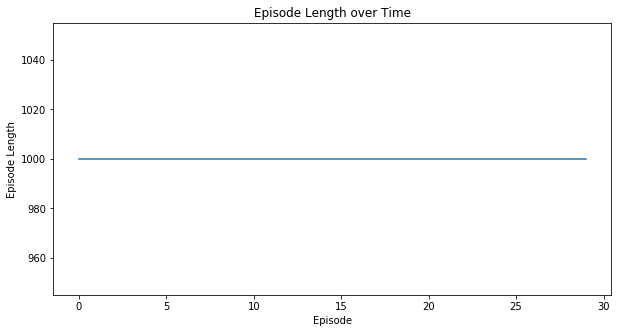

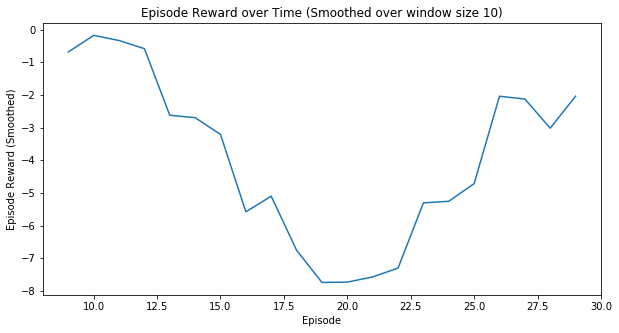

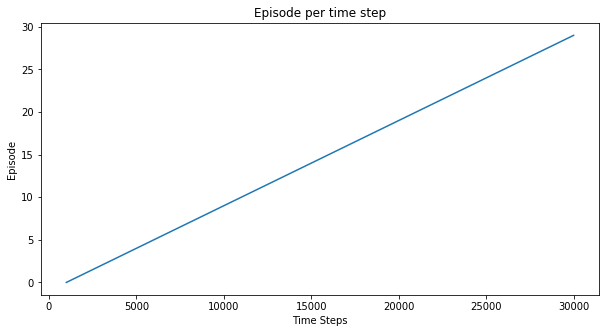

(<matplotlib.figure.Figure at 0x7f9eba187588>,
 <matplotlib.figure.Figure at 0x7f9eb0764eb8>)

In [13]:
plotting.plot_episode_stats(stats, smoothing_window=10)